In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import seaborn as sns

sns.set(font_scale=1.6)

In [3]:
def sum_df_rewards(df, columns, denominator=1, col_title='Total Return'):
    '''
    Sums all columns per row, where the summed columns are not in 'columns'
        df : pandas DataFrame
        columns : list 
            columns not to be summed
    '''
    df = df.set_index(columns)
    df = df.sum(axis=1).div(denominator)
    
    df = df.reset_index()

    df.columns = columns + [col_title]

    return df

def cumsum_df_rewards(df, columns):
    '''
    Sums all columns per row, where the summed columns are not in 'columns'
        df : pandas DataFrame
        columns : list 
            columns not to be summed
    '''
    df = df.set_index(columns)
    df = df.cumsum(axis=1)
    df = df.reset_index()
    
    return df

# Demonstrations Distribution

In [4]:
from lfh.utils.io import load_demonstrations
demonstration_rewards = load_demonstrations("BreakoutDemonstrations", return_demonstrations=False)

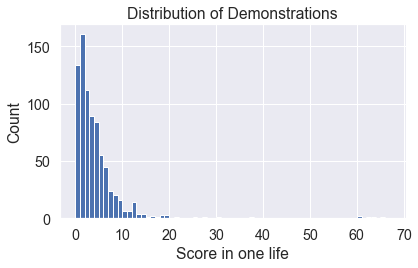

In [5]:
sns.set(font_scale=1.3)

plt.hist(demonstration_rewards, bins = np.arange(0, np.max(demonstration_rewards)))
plt.title("Distribution of Demonstrations")
plt.xlabel("Score in one life")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/demonstration_distribution.pdf")

# Rewards

In [6]:
all_play_returns = []
all_test_returns = []

results_root = Path("results")

min_num_episodes = 100000000

for subdir in [x for x in results_root.iterdir() if x.is_dir()]:

    # load in parameters
    with open(str(subdir/"params.txt")) as f:
        params = json.load(f)
    agent = params["agent"]

    if agent == "uniform_zpd":
        offset = params["zpd"]["offset"]
        radius = params["zpd"]["radius"]
    else:
        offset = None
        radius = None
    
    if agent != "DDQN":
        mix_ratio = params["zpd"]["mix_ratio"]
    else:
        mix_ratio = None


    # load play returns
    play_returns_path = subdir/"play_returns.npy"
    if play_returns_path.exists():
        play_returns = np.load(play_returns_path)
        if len(play_returns) < min_num_episodes:
            min_num_episodes = len(play_returns)
        all_play_returns.append([agent, offset, radius, mix_ratio] + list(play_returns))
    
    # load test returns
    test_returns_path = subdir/"test_returns.npy"
    if test_returns_path.exists():
        test_returns = np.array(np.load(test_returns_path))
        test_returns = test_returns.flatten() #np.mean(test_returns, axis=1)
        
        if len(test_returns) > 500:
            test_returns = test_returns[1::2] # every second 

       

        all_test_returns.append([agent, offset, radius, mix_ratio] + list(test_returns))


In [7]:
cat_cols = ["agent", "offset", "radius", "sampling ratio"]
cols = cat_cols + list(range(500))
all_test_returns = pd.DataFrame(data=all_test_returns, columns = cols )

for i in range(len(all_play_returns)):
    all_play_returns[i] = all_play_returns[i][:min_num_episodes + len(cat_cols)]

cols = cat_cols + list(range(min_num_episodes))
all_play_returns = pd.DataFrame(data= all_play_returns, columns = cols )

## n best configurations

In [8]:
def add_config(df):
    df['Config'] = df["agent"].str.cat(df['offset'].astype(str), sep = " o: ").str.cat(df['radius'].astype(str), sep = " r: ").str.cat(df['sampling ratio'].astype(str), sep = " sr: ")   
    df = df.replace(to_replace=r' .*nan', value='', regex=True)

    return df 

In [9]:
def get_n_best(df, cat_cols, n):
    sum_df = sum_df_rewards(df, cat_cols, denominator=1, col_title='Total Return') #sum of returns
    mean = sum_df.groupby(cat_cols).mean() # take mean across seeds
    stderr = sum_df.groupby(cat_cols).std() / 3
    sum_df = mean.nlargest(n,"Total Return") # highest returns

    n_best_idx = sum_df.index.tolist() # n configurations  of ZPD with highest overall return
    return n_best_idx

def get_n_best_cols(df, cat_cols, n):
    sum_df = sum_df_rewards(df, cat_cols, denominator=1, col_title='Total Return') #sum of returns
    mean = sum_df.groupby(cat_cols).mean() # take mean across seeds
    stderr = sum_df.groupby(cat_cols).std() / 3
    sum_df = mean.nlargest(n,"Total Return") # highest returns

    n_best_idx = sum_df.index.tolist() # n configurations  of ZPD with highest overall return
    
    

In [10]:
all_test_returns['agent'] = all_test_returns['agent'].map({'uniform_zpd': 'ZPD-HD', 'unseq_DDQN': 'U-DDQN', 'DDQN': 'DDQN'})

all_test_returns

agent  offset  radius  sampling ratio    0    1    2    3    4    5  \
0    ZPD-HD    -2.0     0.0          0.0625  2.0  1.0  0.0  0.0  0.0  0.0   
1    ZPD-HD    -2.0    16.0          0.0625  0.0  0.0  0.0  0.0  0.0  0.0   
2    ZPD-HD    -2.0     2.0          0.0625  0.0  0.0  0.0  0.0  0.0  0.0   
3    ZPD-HD    -2.0     4.0          0.0625  0.0  0.0  0.0  0.0  0.0  0.0   
4    ZPD-HD     0.0     0.0          0.0625  1.0  1.0  2.0  1.0  1.0  0.0   
..      ...     ...     ...             ...  ...  ...  ...  ...  ...  ...   
115  ZPD-HD     4.0     2.0          0.2500  1.0  1.0  1.0  1.0  1.0  0.0   
116  ZPD-HD     4.0    16.0          0.2500  2.0  1.0  1.0  1.0  1.0  0.0   
117    DDQN     NaN     NaN             NaN  0.0  0.0  0.0  0.0  0.0  0.0   
118  U-DDQN     NaN     NaN          0.2500  0.0  0.0  0.0  0.0  0.0  0.0   
119  ZPD-HD     4.0     4.0          0.2500  0.0  0.0  0.0  0.0  2.0  0.0   

     ...   490   491   492   493    494   495   496   497   498   499  
0    ...  77.0  13.0   2.0  56.0    1.0   2.0  50.0  14.0  37.0   9.0  
1    ...  77.0   5.0   3.0   3.0    0.0  59.0  28.0  39.0  37.0  66.0  
2    ...  42.0   0.0  19.0  26.0    0.0   4.0  79.0  14.0   0.0  67.0  
3    ...  15.0  83.0   1.0  45.0    4.0  32.0  55.0  74.0   6.0  19.0  
4    ...   1.0   2.0   2.0  93.0  100.0  80.0   1.0   9.0   1.0   1.0  
..   ...   ...   ...   ...   ...    ...   ...   ...   ...   ...   ...  
115  ...   7.0  49.0   6.0  12.0    7.0  49.0   6.0  12.0   7.0  13.0  
116  ...   4.0  59.0   3.0   0.0    0.0  31.0   1.0   1.0  14.0  31.0  
117  ...   7.0  13.0   6.0   2.0   36.0   8.0   2.0  86.0   1.0   6.0  
118  ...  15.0  22.0   6.0  91.0    2.0  18.0  74.0  18.0  74.0  18.0  
119  ...  38.0   2.0   3.0   1.0    5.0   2.0   0.0  40.0   3.0  32.0  

[120 rows x 504 columns]

In [11]:
def plot_n_best(df, cat_cols, num_episodes, rolling = False, rolling_window = 30, xlabel='', ylabel='', title='Default'):
    n_best_idx = get_n_best(df, cat_cols, 1)
    df = df.set_index(cat_cols)


    if rolling:
        df = df.rolling(rolling_window, axis =1 ).mean()
        
    n_best_df = df.loc[n_best_idx]

    n_best_df = n_best_df.reset_index()
    
    
    # add back DDQN and unseq DDQN
    df = df.reset_index()
    n_best_df = n_best_df.append(df[df["agent"] == "U-DDQN"])
    n_best_df = n_best_df.append(df[df["agent"] == "DDQN"])

    n_best_df = add_config(n_best_df)
    n_best_df =n_best_df.replace(to_replace=r'nan:', value='', regex=True)
    n_best_df  =n_best_df.replace(to_replace=r'nan', value='', regex=True)
    df_melt = pd.melt(n_best_df, id_vars= cat_cols + ["Config"], var_name = "Step",value_name= "Reward", value_vars=list(range(0, num_episodes)))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    plot = sns.lineplot(ax = ax, x="Step", y= "Reward", hue="Config", ci = None, data=df_melt)
#     plot.fig.set_figwidth(15)
#     plot.fig.set_figheight(5)
#     plot._legend.remove()

    plt.suptitle(title)
    plot.set(xlabel=xlabel, ylabel=ylabel)
    plt.subplots_adjust(top=0.9)

    plt.legend(loc="best", borderaxespad=0.)
#     sns.plt.legend(loc='best')
    


### n best play returns over rolling average

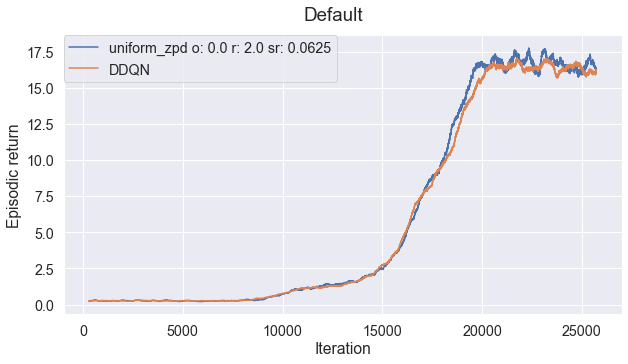

In [12]:
plot_n_best(all_play_returns, cat_cols, min_num_episodes, rolling=True, rolling_window = 300,xlabel="Iteration", ylabel="Episodic return")

plt.savefig("figures/best_episodic_play_rolling_avg_window_300.pdf", bbox_inches = "tight")

In [13]:
from scipy.stats import ttest_ind, sem
n_best_idx = get_n_best(all_test_returns, cat_cols, 1)
unseq_ddqn_idx_quarter = [('U-DDQN', '', '', 0.25)]
unseq_ddqn_idx_sixteenth = [('U-DDQN', '', '', 0.0625)]

ddqn = [('DDQN', '', '', '')]
df1 = sum_df_rewards(all_test_returns, cat_cols, denominator=1, col_title='Total Return').set_index(cat_cols)
n_best_res = df1.loc[n_best_idx]['Total Return'].to_numpy().astype(np.float)
unseq_quarter_res = df1.loc[unseq_ddqn_idx_quarter]['Total Return'].to_numpy().astype(np.float)
unseq_sixteenth_res = df1.loc[unseq_ddqn_idx_sixteenth]['Total Return'].to_numpy().astype(np.float)
ddqn_res = df1.loc[ddqn]['Total Return'].to_numpy().astype(np.float)

target = n_best_res
test_results = {}

for key, res in [('ddqn', ddqn_res), (str(n_best_idx), n_best_res), 
                 ('unseq_0.25', unseq_quarter_res), ('unseq_0.0625', unseq_sixteenth_res),
                ]:
    _, p = ttest_ind(res, target, equal_var=False)
    test_results[key] = {
        'mean': res.mean(),
        'std_err': sem(res),
        'p': p
    }
test_results


{'ddqn': {'mean': 7548.0,
  'std_err': 62.303022933615885,
  'p': 0.006041740922759336},
 "[('ZPD-HD', -2.0, 4.0, 0.25)]": {'mean': 8497.25,
  'std_err': 163.24744765743404,
  'p': 1.0},
 'unseq_0.25': {'mean': 8706.333333333334,
  'std_err': 556.7433080972875,
  'p': 0.7484686481376146},
 'unseq_0.0625': {'mean': 8311.666666666666,
  'std_err': 296.13979431643054,
  'p': 0.6190922138328656}}

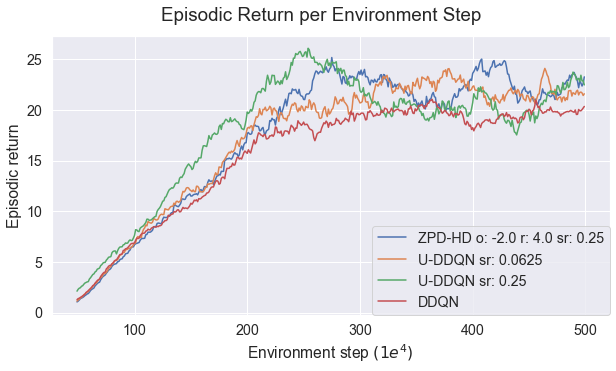

In [14]:
plot_n_best(all_test_returns, cat_cols, 500, rolling=True, rolling_window=50, xlabel="Environment step $(1e^{4})$", ylabel="Episodic return", title="Episodic Return per Environment Step")

plt.savefig("figures/best_episodic_test_rolling_avg_window_50.pdf", bbox_inches = "tight")

## Cumulative

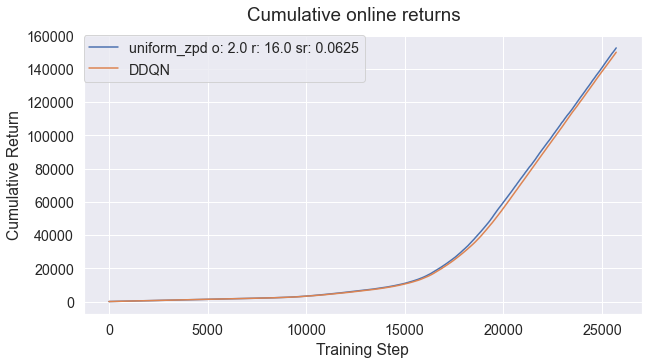

In [15]:
# Play
plot_n_best(cumsum_df_rewards(all_play_returns, cat_cols), cat_cols, min_num_episodes, xlabel="Training Step", ylabel="Cumulative Return", title="Cumulative online returns")
plt.savefig("figures/best_cumulative_play.pdf", bbox_inches = "tight")

In [16]:
cumsum_df = cumsum_df_rewards(all_test_returns, cat_cols)
cumsum_mean = cumsum_df.groupby(cat_cols).mean()
# sum_df = cumsum_mean.nlargest(n,"Total Return") # highest returns

# n_best_idx = sum_df.index.tolist() # n configurations  of ZPD with highest overall return
# return n_best_idx

cumsum_mean

0         1         2         3    \
agent  offset radius sampling ratio                                           
ZPD-HD -2.0   0.0    0.0625          0.666667  1.000000  1.000000  1.333333   
                     0.2500          0.250000  0.250000  0.750000  1.000000   
              2.0    0.0625          0.666667  0.666667  0.666667  0.666667   
                     0.2500          0.500000  1.250000  1.750000  2.250000   
              4.0    0.0625          0.000000  0.000000  0.000000  0.000000   
                     0.2500          0.000000  0.500000  0.500000  0.500000   
              16.0   0.0625          0.666667  1.000000  1.666667  2.000000   
                     0.2500          0.000000  0.500000  0.500000  0.500000   
        0.0   0.0    0.0625          0.333333  0.666667  1.333333  1.666667   
                     0.2500          0.000000  0.000000  0.750000  0.750000   
              2.0    0.0625          0.000000  0.000000  0.000000  0.000000   
                     0.2500          0.500000  0.750000  1.000000  1.250000   
              4.0    0.0625          0.000000  0.666667  1.333333  1.666667   
                     0.2500          0.750000  1.250000  1.750000  2.250000   
              16.0   0.0625          0.666667  1.333333  1.666667  2.333333   
                     0.2500          0.000000  0.500000  0.500000  0.500000   
        2.0   0.0    0.0625          0.333333  0.666667  1.333333  1.666667   
                     0.2500          0.250000  0.750000  1.750000  2.000000   
              2.0    0.0625          1.333333  1.666667  1.666667  1.666667   
                     0.2500          0.250000  0.500000  0.750000  1.000000   
              4.0    0.0625          0.666667  1.666667  1.666667  2.666667   
                     0.2500          1.250000  1.750000  2.000000  2.250000   
              16.0   0.0625          0.666667  0.666667  0.666667  1.000000   
                     0.2500          0.250000  0.750000  0.750000  0.750000   
        4.0   0.0    0.0625          0.000000  0.666667  0.666667  1.333333   
                     0.2500          0.333333  0.333333  2.000000  2.333333   
              2.0    0.0625          0.666667  0.666667  0.666667  0.666667   
                     0.2500          0.333333  0.666667  1.000000  1.333333   
              4.0    0.0625          0.000000  0.000000  0.666667  1.333333   
                     0.2500          0.000000  0.000000  0.000000  0.000000   
              16.0   0.0625          0.333333  0.666667  1.333333  1.666667   
                     0.2500          1.333333  2.000000  2.666667  3.333333   

                                          4         5         6         7    \
agent  offset radius sampling ratio                                           
ZPD-HD -2.0   0.0    0.0625          1.666667  2.333333  2.666667  2.666667   
                     0.2500          1.500000  1.500000  2.000000  2.250000   
              2.0    0.0625          0.666667  1.333333  2.333333  2.333333   
                     0.2500          2.750000  3.750000  4.000000  4.500000   
              4.0    0.0625          0.000000  0.666667  1.333333  1.333333   
                     0.2500          0.500000  1.000000  1.250000  1.750000   
              16.0   0.0625          2.333333  2.333333  2.333333  2.333333   
                     0.2500          0.500000  0.500000  0.500000  1.250000   
        0.0   0.0    0.0625          2.000000  2.000000  2.000000  3.000000   
                     0.2500          0.750000  1.000000  1.000000  1.750000   
              2.0    0.0625          0.000000  1.000000  1.333333  1.333333   
                     0.2500          1.500000  1.750000  2.000000  2.250000   
              4.0    0.0625          2.000000  2.000000  2.666667  2.666667   
                     0.2500          2.750000  3.000000  3.250000  3.250000   
              16.0   0.0625          3.000000  3.333333  3.666667  3.666667   
            

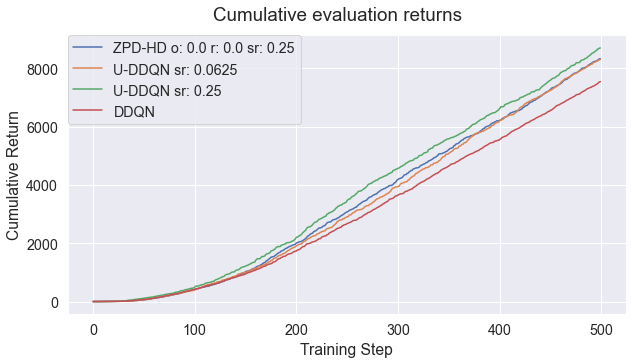

In [17]:
# test
plot_n_best(cumsum_df_rewards(all_test_returns, cat_cols), cat_cols, 500, xlabel="Training Step", ylabel="Cumulative Return", title="Cumulative evaluation returns")
plt.savefig("figures/best_cumulative_test.pdf", bbox_inches = "tight")

# Effect of mix ratio, width, offset

In [18]:
def plot_params(df, cat_cols, num_episodes, rolling = False, rolling_window = 30, xlabel='', ylabel='', title="Default"):
    df = df.set_index(cat_cols)
    if rolling:
        df = df.rolling(rolling_window, axis =1 ).mean()
    # add back DDQN and unseq DDQN
    df = df.reset_index()
    df= add_config(df)
    df=df.replace(to_replace=r'nan:', value='', regex=True)
    df =df.replace(to_replace=r'nan', value='', regex=True)
    df_melt = pd.melt(df, id_vars= cat_cols + ["Config"], var_name = "Step",value_name= "Reward", value_vars=list(range(0, num_episodes)))

    plot = sns.relplot(x="Step", y= "Reward", hue="radius",ci = None, kind='line', col='sampling ratio', row='offset', data=df_melt, palette=sns.color_palette("crest", as_cmap=True))
    plot.set(xlabel=xlabel, ylabel=ylabel)
    plt.subplots_adjust(top=0.9)
    plt.suptitle(title)


In [19]:
def plot_offset(df, cat_cols, num_episodes, rolling = False, rolling_window = 30, xlabel='', ylabel='', title="Default"):
    df = df.set_index(cat_cols)
    if rolling:
        df = df.rolling(rolling_window, axis =1 ).mean()
    # add back DDQN and unseq DDQN
    df = df.reset_index()
    df= add_config(df)
    df=df.replace(to_replace=r'nan:', value='', regex=True)
    df =df.replace(to_replace=r'nan', value='', regex=True)
    df_melt = pd.melt(df, id_vars= cat_cols + ["Config"], var_name = "Step",value_name= "Reward", value_vars=list(range(0, num_episodes)))

    plot = sns.relplot(x="Step", y= "Reward",ci = None, kind='line', col='sampling ratio', hue='offset', data=df_melt, palette=sns.color_palette("crest", as_cmap=True))
    plot.set(xlabel=xlabel, ylabel=ylabel)
    plt.subplots_adjust(top=0.85)
    plt.suptitle(title)


In [20]:
def plot_radius(df, cat_cols, num_episodes, rolling = False, rolling_window = 30, xlabel='', ylabel='', title="Default"):
    df = df.set_index(cat_cols)
    if rolling:
        df = df.rolling(rolling_window, axis =1 ).mean()
    # add back DDQN and unseq DDQN
    df = df.reset_index()
    df= add_config(df)
    df= df.replace(to_replace=r'nan:', value='', regex=True)
    df = df.replace(to_replace=r'nan', value='', regex=True)
    df_melt = pd.melt(df, id_vars= cat_cols + ["Config"], var_name = "Step",value_name= "Reward", value_vars=list(range(0, num_episodes)))

    plot = sns.relplot(x="Step", y= "Reward",ci = None, kind='line', col='sampling ratio', hue='radius', data=df_melt, palette=sns.color_palette("crest", as_cmap=True))
    plot.set(xlabel=xlabel, ylabel=ylabel)
    plt.subplots_adjust(top=0.85)
    plt.suptitle(title)


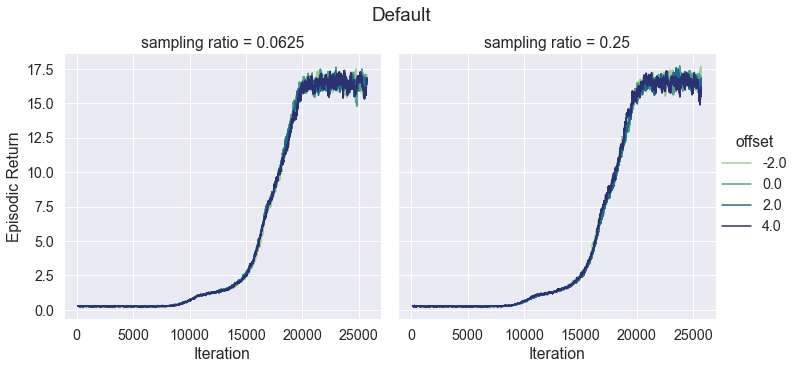

In [21]:
# play
plot_offset(all_play_returns, cat_cols, min_num_episodes,rolling = True, rolling_window = 100, xlabel="Iteration", ylabel="Episodic Return")
plt.savefig("figures/param_offset_episodic_play_rolling_avg_window_100.pdf", bbox_inches = "tight")

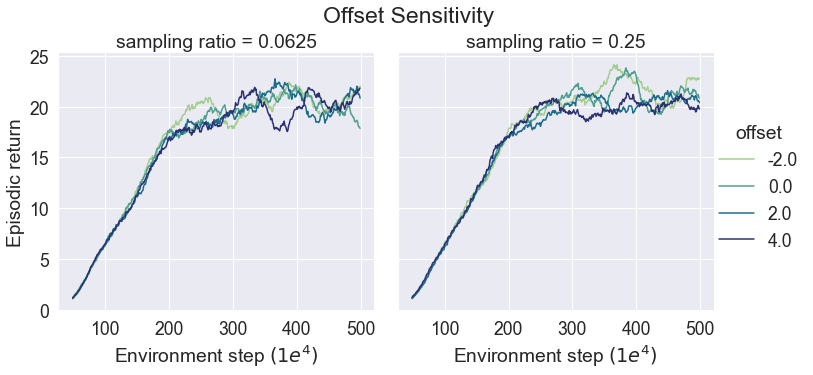

In [25]:
# test
sns.set(font_scale=1.6)
plot_offset(all_test_returns, cat_cols, 500, rolling = True, rolling_window = 50, xlabel="Environment step $(1e^{4})$", ylabel="Episodic return", title="Offset Sensitivity")
plt.savefig("figures/param_offset_episodic_test_rolling_avg_window_50.pdf", bbox_inches = "tight")

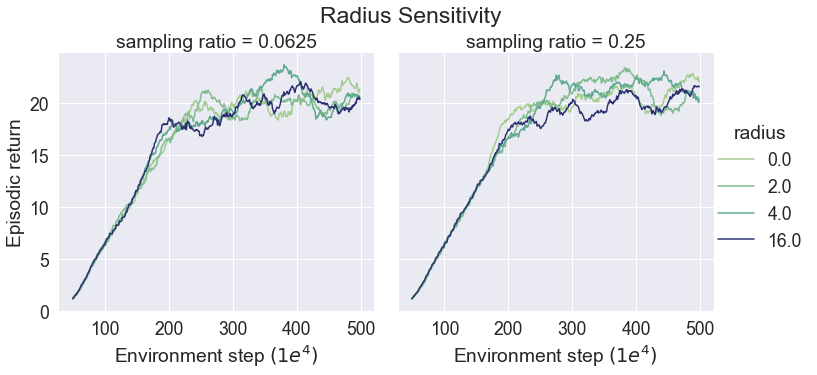

In [26]:
# play
sns.set(font_scale=1.6)

plot_radius(all_test_returns, cat_cols, 500,rolling = True, rolling_window = 50, xlabel="Environment step $(1e^{4})$", ylabel="Episodic return", title="Radius Sensitivity")
plt.savefig("figures/param_radius_episodic_test_rolling_avg_window_50.pdf", bbox_inches = "tight")

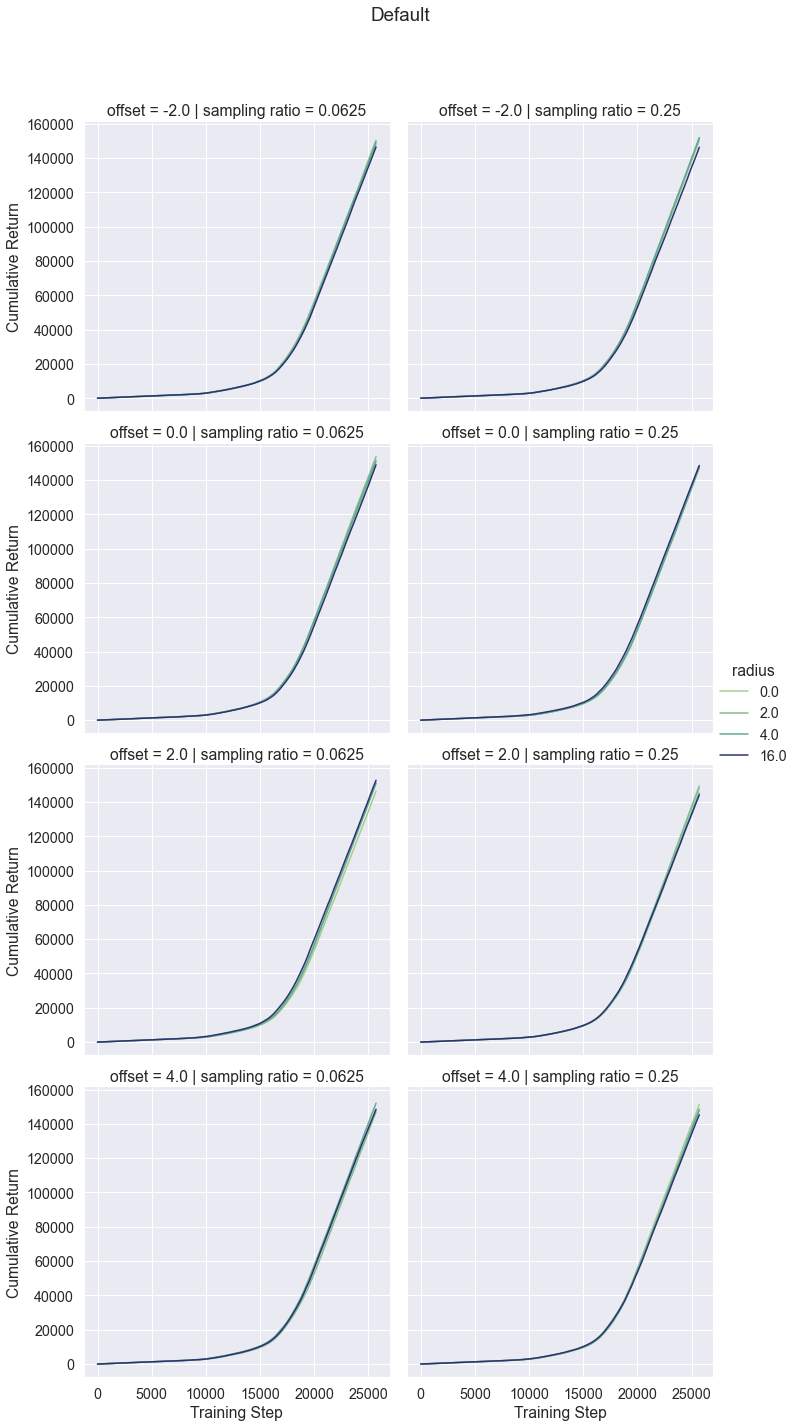

In [24]:
# play
plot_params(cumsum_df_rewards(all_play_returns,cat_cols), cat_cols, min_num_episodes, xlabel="Training Step", ylabel="Cumulative Return")
plt.savefig("figures/param_cumulative_play.pdf", bbox_inches = "tight")

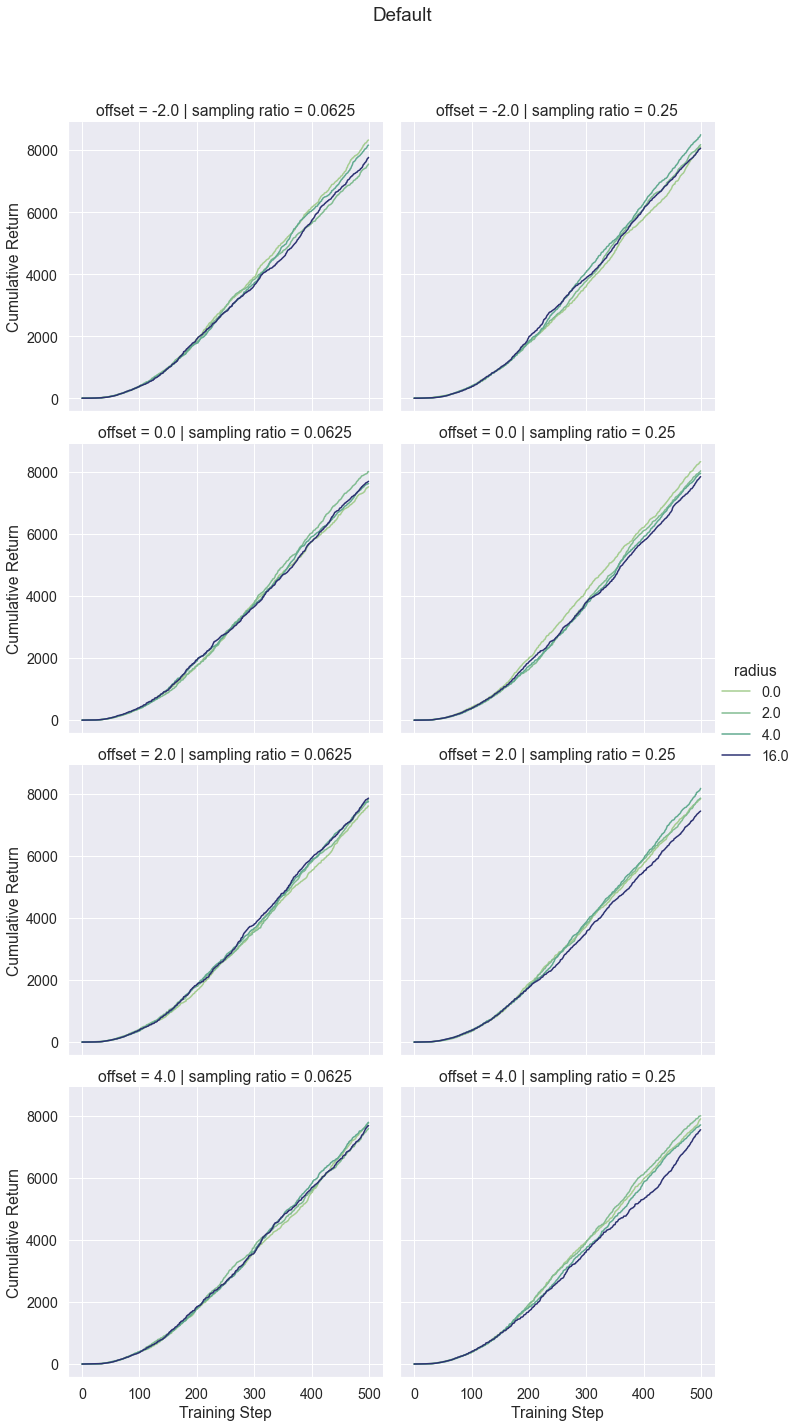

In [25]:
# test
plot_params(cumsum_df_rewards(all_test_returns,cat_cols), cat_cols, 500, xlabel="Training Step", ylabel="Cumulative Return")
plt.savefig("figures/param_cumulative_test.pdf", bbox_inches = "tight")

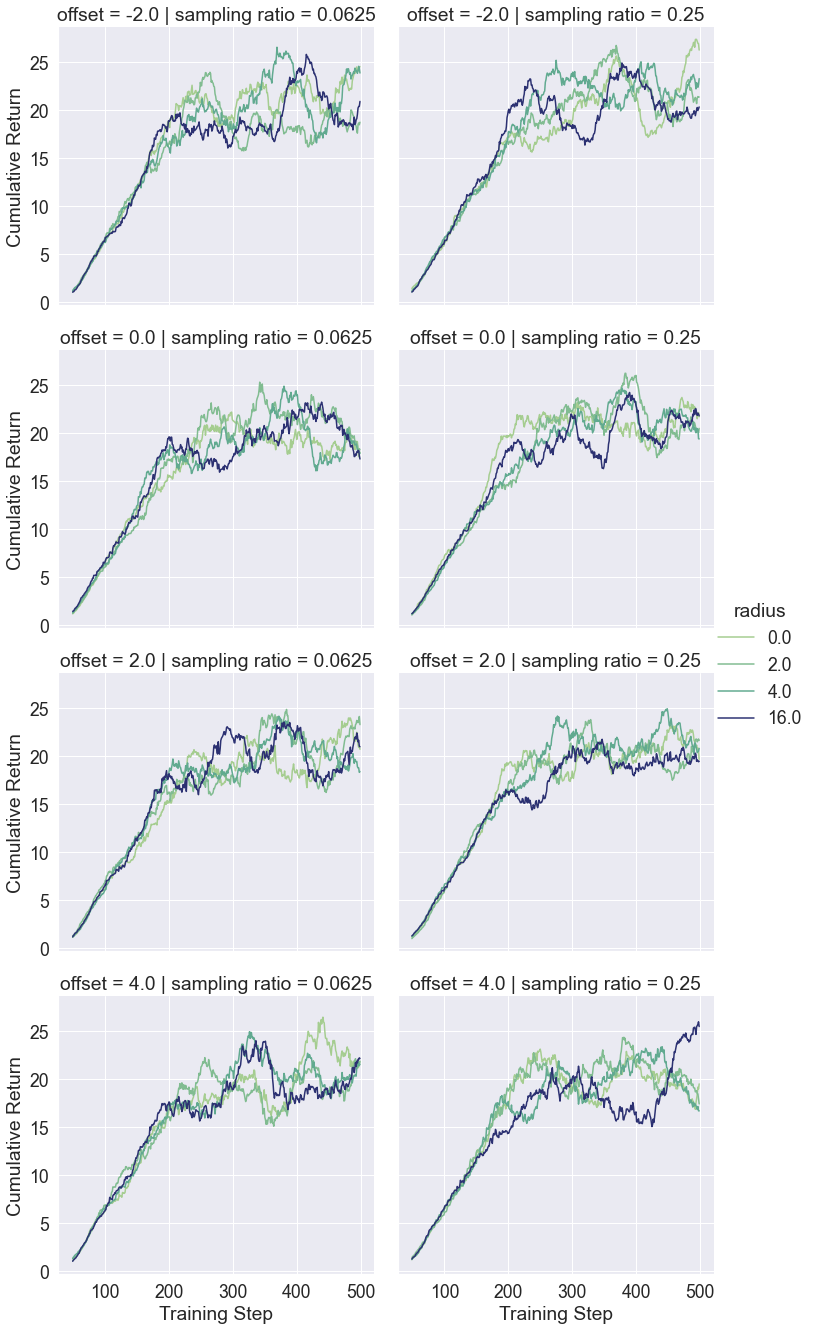

In [26]:
# test
sns.set(font_scale=1.6)
plot_params(all_test_returns, cat_cols, 500, xlabel="Training Step", ylabel="Cumulative Return", rolling=True, rolling_window = 50, title="")
plt.savefig("figures/param_test.pdf", bbox_inches = "tight")

# Loss Ablations

In [27]:
# load supervised results
sup_play_returns = []
sup_test_returns = []

results_root = Path("results_supervised")

min_num_episodes = 100000000

for subdir in [x for x in results_root.iterdir() if x.is_dir()]:

    # load in parameters
    with open(str(subdir/"params.txt")) as f:
        params = json.load(f)
    agent = params["agent"]

    if agent == "uniform_zpd":
        offset = params["zpd"]["offset"]
        radius = params["zpd"]["radius"]
    else:
        offset = None
        radius = None
    
    if agent != "DDQN":
        mix_ratio = params["zpd"]["mix_ratio"]
    else:
        mix_ratio = None


    # load play returns
    play_returns_path = subdir/"play_returns.npy"
    if play_returns_path.exists():
        play_returns = np.load(play_returns_path)
        if len(play_returns) < min_num_episodes:
            min_num_episodes = len(play_returns)
        sup_play_returns.append([agent, offset, radius, mix_ratio] + list(play_returns))
    
    # load test returns
    test_returns_path = subdir/"test_returns.npy"
    if test_returns_path.exists():
        test_returns = np.array(np.load(test_returns_path))
        test_returns = test_returns.flatten() #np.mean(test_returns, axis=1)
        
        if len(test_returns) > 500:
            test_returns = test_returns[1::2] # every second 

       

        sup_test_returns.append([agent, offset, radius, mix_ratio] + list(test_returns))

In [28]:
cat_cols = ["agent", "offset", "radius", "sampling ratio"]
cols = cat_cols + list(range(500))
sup_test_returns = pd.DataFrame(data= sup_test_returns, columns = cols )

for i in range(len(sup_play_returns)):
    sup_play_returns[i] = sup_play_returns[i][:min_num_episodes + len(cat_cols)]

cols = cat_cols + list(range(min_num_episodes))
sup_play_returns = pd.DataFrame(data= sup_play_returns, columns = cols )


sup_test_returns.insert(0, "Supervised", "True")
sup_play_returns.insert(0, "Supervised", "True")

In [29]:
all_test_returns.insert(0, "Supervised", "False")
all_play_returns.insert(0, "Supervised", "False")

In [30]:
test_returns = sup_test_returns.append(all_test_returns)
play_returns = sup_play_returns.append(all_play_returns)

test_returns = test_returns[test_returns["sampling ratio"] == 1/4]
play_returns = play_returns[play_returns["sampling ratio"] == 1/4]

In [31]:
test_returns

Supervised        agent  offset  radius  sampling ratio    0    1    2  \
0         True  uniform_zpd    -2.0     2.0            0.25  0.0  0.0  0.0   
1         True  uniform_zpd     0.0     2.0            0.25  0.0  0.0  0.0   
2         True  uniform_zpd    -2.0    16.0            0.25  0.0  0.0  0.0   
3         True  uniform_zpd     0.0    16.0            0.25  0.0  0.0  0.0   
4         True  uniform_zpd     0.0     4.0            0.25  0.0  1.0  0.0   
..         ...          ...     ...     ...             ...  ...  ...  ...   
114      False       ZPD-HD     4.0     0.0            0.25  0.0  0.0  2.0   
115      False       ZPD-HD     4.0     2.0            0.25  1.0  1.0  1.0   
116      False       ZPD-HD     4.0    16.0            0.25  2.0  1.0  1.0   
118      False       U-DDQN     NaN     NaN            0.25  0.0  0.0  0.0   
119      False       ZPD-HD     4.0     4.0            0.25  0.0  0.0  0.0   

       3    4  ...   490   491   492   493   494   495   496   497   498   499  
0    0.0  0.0  ...  16.0  14.0   2.0   1.0   1.0  12.0  13.0   5.0  52.0  11.0  
1    0.0  0.0  ...  20.0   8.0   7.0   1.0   5.0  16.0   5.0   6.0   3.0   1.0  
2    0.0  0.0  ...  24.0  18.0   4.0   2.0   0.0  24.0  18.0   4.0   2.0   0.0  
3    0.0  0.0  ...   2.0  12.0   3.0  12.0  53.0   2.0  12.0   3.0  12.0  53.0  
4    0.0  0.0  ...  22.0   5.0   8.0  45.0   0.0  22.0   5.0   8.0  45.0   0.0  
..   ...  ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
114  0.0  0.0  ...  17.0  26.0  32.0   7.0   1.0  86.0   6.0  28.0   6.0   3.0  
115  1.0  1.0  ...   7.0  49.0   6.0  12.0   7.0  49.0   6.0  12.0   7.0  13.0  
116  1.0  1.0  ...   4.0  59.0   3.0   0.0   0.0  31.0   1.0   1.0  14.0  31.0  
118  0.0  0.0  ...  15.0  22.0   6.0  91.0   2.0  18.0  74.0  18.0  74.0  18.0  
119  0.0  2.0  ...  38.0   2.0   3.0   1.0   5.0   2.0   0.0  40.0   3.0  32.0  

[113 rows x 505 columns]

In [32]:
def plot_ablation(df, cat_cols, num_episodes, rolling = False, rolling_window = 30, xlabel='', ylabel='', title="Default"):
    df = df.set_index(cat_cols)
    if rolling:
        df = df.rolling(rolling_window, axis =1 ).mean()
    # add back DDQN and unseq DDQN
    df = df.reset_index()
    df= add_config(df)

    df_melt = pd.melt(df, id_vars= cat_cols + ["Config"], var_name = "Step",value_name= "Reward", value_vars=list(range(0, num_episodes)))
    fig, ax = plt.subplots(figsize=(7, 5))
    #plot = sns.relplot(x="Step", y= "Reward", hue="Supervised",ci = None, kind='line', row='radius', col='offset', data=df_melt)
    plot = sns.lineplot(ax=ax, x="Step", y= "Reward", hue="Supervised", ci = None, data=df_melt)
    plt.suptitle(title)
    plot.set(xlabel=xlabel, ylabel=ylabel)
    plt.subplots_adjust(top=0.9)

    plt.legend(loc="best", borderaxespad=0.)

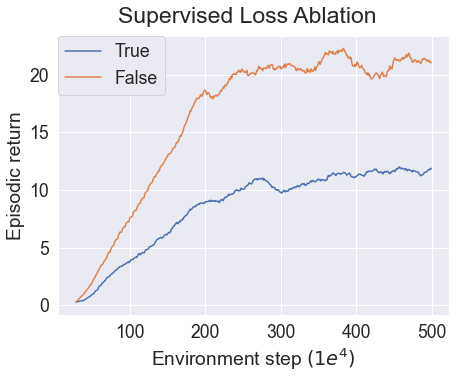

In [34]:
plot_ablation(test_returns, cat_cols + ["Supervised"], 500, rolling = True, rolling_window = 30, xlabel="Environment step $(1e^{4})$", ylabel="Episodic return", title="Supervised Loss Ablation")
plt.savefig("figures/ablation.pdf", bbox_inches='tight')